In [1]:
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import os
import pickle
from pathlib import Path
import rootutils
from scipy.spatial.distance import squareform
import seaborn as sns
# import torch
# from torchvision import transforms

ROOT = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)

from src.analysis import cka, rsa
from rsa import get_rsa_matrix
from src.analysis.representations import (
    get_average_class_representations, 
    get_class_representations,
    compute_cka_and_kernel_matrices
)
from src.data.data_module import MyDataModule
from src.model.model_module import LitMML, MLMWrapper
from src.model.utils import get_model_and_processor
from src.utils.utils import save_as_pickle

### Workflow
1. Get model representations for each class of a dataset (average class representation)
2. Compute RDM by measuring (dis-)similarites of class representations
3. Compute RSA by measuring (dis-)similarities of RDMs

### Get model representations
1. Load model & dataset
2. Compute representations and calculate average class representations
3. Store average class representations

In [ ]:
dataset_name = "CIFAR10"
checkpoints = "full_dataset_aug_mlm"
which_layer = "encoder" #"projection"

device = "cuda:1"

CKPT_DIR = Path("/home/data/bhavin/0.1_and_0.5_ckpts")
CKPT_CONFIG_DIR = os.path.join(ROOT, "configs/checkpoints")
SAVE_DATA_DIR = os.path.join(ROOT, "data", "representations")
SAVE_FIGURES_DIR = os.path.join(ROOT, "plots")
cfg_checkpoints = OmegaConf.load(os.path.join(CKPT_CONFIG_DIR, f"{checkpoints}.yaml"))

In [3]:
# Load config
cfg_path = "../../configs"

overrides = [f"checkpoints={checkpoints}",
             f"data.datasets=[{dataset_name}]",
            ]

with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(config_name="test.yaml", overrides=overrides)
    #config = compose(overrides=[f"data.datasets=[f{DATASET}]"])
print(cfg)

{'model': {'model': {'image_encoder_name': 'google/vit-base-patch16-224', 'text_encoder_name': 'google-bert/bert-base-uncased', 'tokenizer': {'use_fast': False}}}, 'data': {'datasets': ['CIFAR10'], 'dataloader': {'coco_val': {'batch_size': 128, 'shuffle': False}, 'test': {'batch_size': 128, 'shuffle': False, 'num_workers': 8, 'pin_memory': True}}, 'root': '${paths.data_dir}', 'Places365': {'root': '/home/data/places365/'}, 'use_subset_probe': {'value': False, 'subset_fraction': 0.1}, 'dataset': {'val': ['coco_val_dummy'], 'transforms': {'enabled': True, 'RandAugment': {'num_ops': 3, 'magnitude': 8}}, 'max_seq_length': 72, 'coco': {'root': '/home/data/mscoco_captions/', 'split_train': '/home/phisch/multimodal/my_datasets/coco_karpathy_train.json', 'split_val': '${paths.root_dir}src/data/datasets/coco_karpathy_val.json', 'split_test': '/home/phisch/multimodal/my_datasets/coco_karpathy_test.json'}, 'vg': {'data_dir': '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/VG_Bhavin/VG'}, 

In [4]:
# Load model
model, processor = get_model_and_processor(cfg.model)
model = MLMWrapper(model)

In [5]:
# Load dataset
data_module = MyDataModule(
    cfg.data,
    processor,
)
all_test_dataloaders = data_module.get_test_dataloaders()
dataloader = all_test_dataloaders[dataset_name]["test"]
num_classes = dataloader.dataset.num_classes
class_names = dataloader.dataset.classnames
print(num_classes)
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
print(f"Computing class representations for checkpoints {checkpoints}")

save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

for ckpt in cfg_checkpoints:
    model_name = cfg_checkpoints[ckpt]["model"]
    ckpt_path = cfg_checkpoints[ckpt]["path"]
    # files = os.listdir(os.path.join(CKPT_DIR, ckpt))
    # if "last.ckpt" in files:
    #     files.remove("last.ckpt")
    # ckpt_path = os.path.join(CKPT_DIR, ckpt, files[0])
    
    # Load checkpoint
    print(f"Loading model {ckpt}:{model_name} from checkpoint", ckpt_path)    
    lit_model = LitMML.load_from_checkpoint(ckpt_path, model=model, processor=processor, map_location=device)
    model, processor = lit_model.model, lit_model.processor
    if which_layer == "encoder":
        forward_func=lambda x: model.basemodel.vision_model( #forward_func=lambda x: model.vision_model(
                        pixel_values=x
                    ).last_hidden_state[:, 0, :] # CLS token
    elif which_layer == "projection":
        forward_func = lambda x: model.get_image_features(pixel_values=x)
    # del lit_model
    # torch.cuda.empty_cache()
    
    print("Computing class representations")
    save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl")
    class_representations = get_class_representations(dataloader,
                                                      forward_func,
                                                      num_classes,
                                                      device,
                                                      )
    avg_class_representations = get_average_class_representations(class_representations)
    save_as_pickle(avg_class_representations, save_file_path)
    print(f"Saved: {save_file_path}")


Computing class representations for checkpoints full_dataset_aug_mlm
Loading model 3burj4np:CLIP from checkpoint /home/data/bhavin/higher_augmentations_ckpts/3burj4np/last.ckpt


/home/phisch/venv_py3.8/py3.8/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.3, which is newer than your current Lightning version: v2.2.0.post0


Computing class representations


Getting features...: 100%|██████████| 79/79 [02:04<00:00,  1.57s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Loading model 7m9tx2jf:CLIP + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/7m9tx2jf/last.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Loading model 95ddsmmz:CLIP + SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/95ddsmmz/last.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:57<00:00,  1.48s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Loading model ng70n4a4:CLIP + SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/ng70n4a4/last.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:53<00:00,  1.44s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Loading model p99godxb:SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/p99godxb/last.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Loading model xpbl8wfc:SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/xpbl8wfc/last.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Loading model bj2tw5qt:SimCLR + ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/bj2tw5qt/ckpt-epoch=84-loss-val=0.599.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-bj2tw5qt-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-bj2tw5qt-mean_class_reps-vis_enc.pkl
Loading model khb9ltyn:CLIP + ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/khb9ltyn/ckpt-epoch=49-loss-val=1.601.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-khb9ltyn-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-khb9ltyn-mean_class_reps-vis_enc.pkl
Loading model mkqp8hhx:ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/mkqp8hhx/ckpt-epoch=74-loss-val=0.885.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:57<00:00,  1.48s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-mkqp8hhx-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-mkqp8hhx-mean_class_reps-vis_enc.pkl
Loading model txva2y48:CLIP + SimCLR + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/txva2y48/ckpt-epoch=79-loss-val=1.435.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-txva2y48-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-txva2y48-mean_class_reps-vis_enc.pkl
Loading model shf56cne:CLIP + MLM from checkpoint /home/data/bhavin/shf56cne/ckpt-epoch=94-loss-val=2.031.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:55<00:00,  1.46s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-shf56cne-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-shf56cne-mean_class_reps-vis_enc.pkl
Loading model gtp8w6c4:SimCLR + MLM from checkpoint /home/data/bhavin/gtp8w6c4/ckpt-epoch=39-loss-val=0.851.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:55<00:00,  1.47s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-gtp8w6c4-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-gtp8w6c4-mean_class_reps-vis_enc.pkl
Loading model tibwkymx:CLIP + ITM + SimCLR + MLM from checkpoint /home/data/bhavin/tibwkymx/ckpt-epoch=119-loss-val=1.134.ckpt
Computing class representations


Getting features...: 100%|██████████| 79/79 [01:57<00:00,  1.49s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-tibwkymx-mean_class_reps-vis_enc.pkl
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-tibwkymx-mean_class_reps-vis_enc.pkl


## RDM

In [7]:
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/

/tmp/ipykernel_469582/1643773678.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


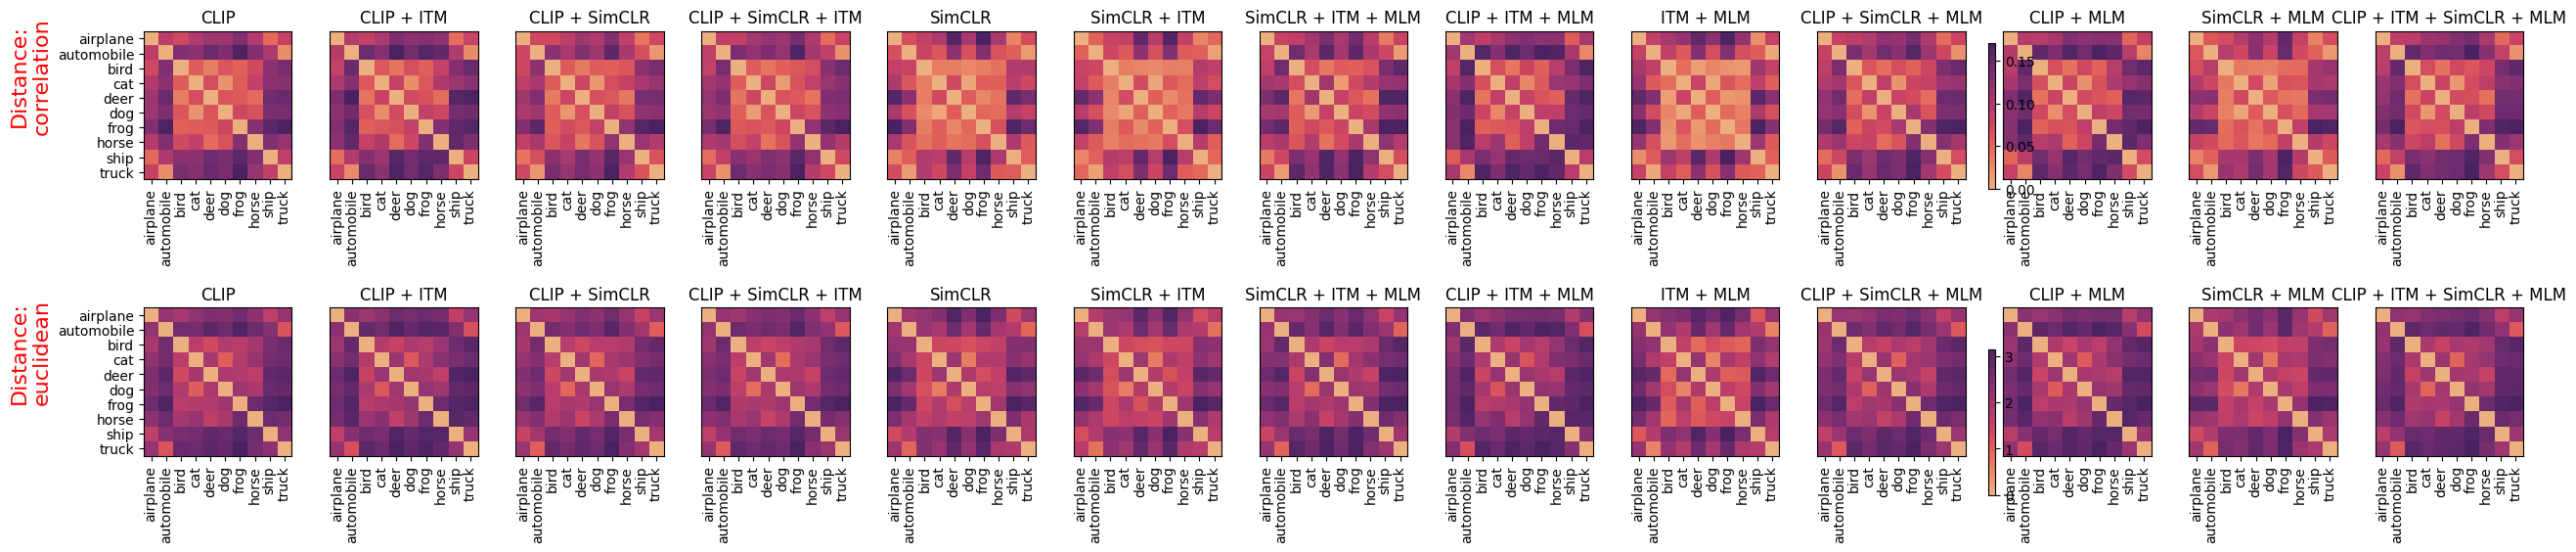

In [9]:
import seaborn as sns

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "euclidean",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(mean_class_representations), 
    figsize=(2 * len(mean_class_representations), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=1.0)

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])


    for model_idx, model in enumerate(mean_class_representations):
        represenations = mean_class_representations[model]
        a = rsa.get_rdm(represenations, metric=method)
        # RDM_DICT[method][key] = a
        img = axs[method_idx, model_idx].imshow(
            squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
        )
        # plt.colorbar(img, ax=axs[method_idx, model_idx], fraction=0.04)
        if model_idx == len(mean_class_representations) - 1:
            fig.colorbar(img, ax=axs[method_idx, :], location='right')#, fraction=0.001)
        # fig.tight_layout()
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        # axs[methodind,keyind].set_yticks([x for x in range(10)],['']*10)

        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )
        # fig.colorbar(im,cax=axs[methodind,keyind])

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

## RSA

In [5]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps.pkl'

In [11]:
checkpoints = "full_dataset_aug_mlm"

# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_mlm")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_aug")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl"
    if "MLM" in cfg_checkpoints[ckpt]["model"]:
        file_path = os.path.join(save_file_dir, file_name)
    else:
        file_path = os.path.join(save_file_dir_2, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/

In [7]:
for ckpt in cfg_checkpoints:
    print(cfg_checkpoints[ckpt]["model"], ckpt)

CLIP 3burj4np
CLIP + ITM 7m9tx2jf
CLIP + SimCLR 95ddsmmz
CLIP + SimCLR + ITM ng70n4a4
SimCLR p99godxb
SimCLR + ITM xpbl8wfc
SimCLR + ITM + MLM bj2tw5qt
CLIP + ITM + MLM khb9ltyn
ITM + MLM mkqp8hhx
CLIP + SimCLR + MLM txva2y48
CLIP + MLM shf56cne
SimCLR + MLM gtp8w6c4
CLIP + ITM + SimCLR + MLM tibwkymx


In [12]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    "riemann",
]

def get_rsa_matrix(reps, similarity_measure):
    rsa_matrix = np.zeros((len(reps), len(reps)))
    for keyind1, key1 in enumerate(reps):
        for keyind2, key2 in enumerate(reps):
            rdm1 = rsa.get_rdm(reps[key1])
            rdm2 = rsa.get_rdm(reps[key2])

            rsaval = rsa.get_rsa(rdm1, rdm2, similarity_measure=similarity_measure)
            # print (rsaval)
            if similarity_measure != "riemann":
                rsa_matrix[keyind1, keyind2] = rsaval.statistic
            else:
                rsa_matrix[keyind1, keyind2] = rsaval
    return rsa_matrix

# model_order = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
# model_order = [ # full_dataset_mlm
#     "shf56cne", # CLIP + MLM
#     "khb9ltyn", # "CLIP + ITM + MLM"
#     "txva2y48", # "CLIP + SimCLR + MLM"
#     "tibwkymx", # "CLIP + ITM + SimCLR + MLM
#     "bj2tw5qt", # "SimCLR + ITM + MLM"
#     "gtp8w6c4", # "SimCLR + MLM"
#     "mkqp8hhx", # "ITM + MLM"
# ]
# model_order = [ # full_dataset_aug
#     "3burj4np", # CLIP
#     "7m9tx2jf", # CLIP + ITM
#     "95ddsmmz", # CLIP + SimCLR
#     "ng70n4a4", # CLIP + SimCLR + ITM
#     "xpbl8wfc", # SimCLR + ITM
#     "p99godxb", # SimCLR
# ]
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + ITM + SimCLR + MLM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + ITM + MLM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
mean_class_representations = {model: mean_class_representations[model] for model in model_order}
# for model in model_order:

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

NameError: name 'DATASET_SPLIT' is not defined

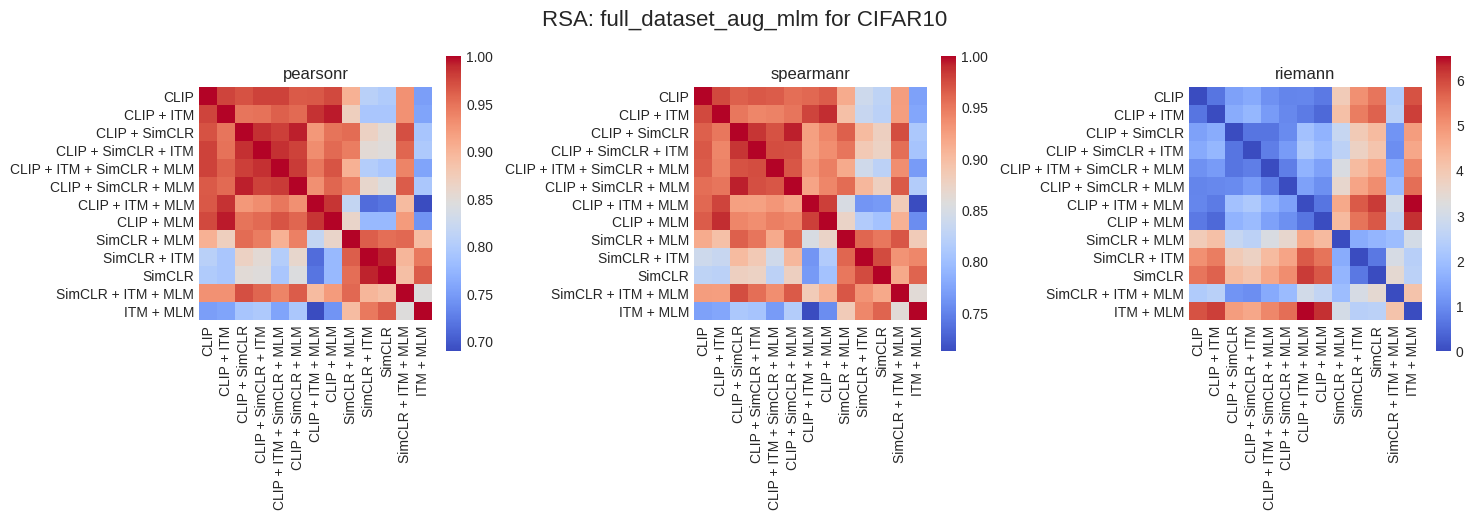

In [13]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
plt.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=16)

for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(mean_class_representations, similarity_measure=sim)
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(len(mean_class_representations.keys()))], 
        [cfg_checkpoints[k]["model"] for k in mean_class_representations.keys()],
    )
    plt.xticks(
        [x for x in range(len(mean_class_representations.keys()))],
        [cfg_checkpoints[k]["model"] for k in mean_class_representations.keys()],
        rotation=90,
    )
    plt.colorbar()#fraction=0.045)

plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_FIGURES_DIR, f"RSA-{DATASET_SPLIT}.png"), bbox_inches="tight"
)

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

/tmp/ipykernel_535556/3173755742.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = hierarchy.linkage(rsa_matrix)


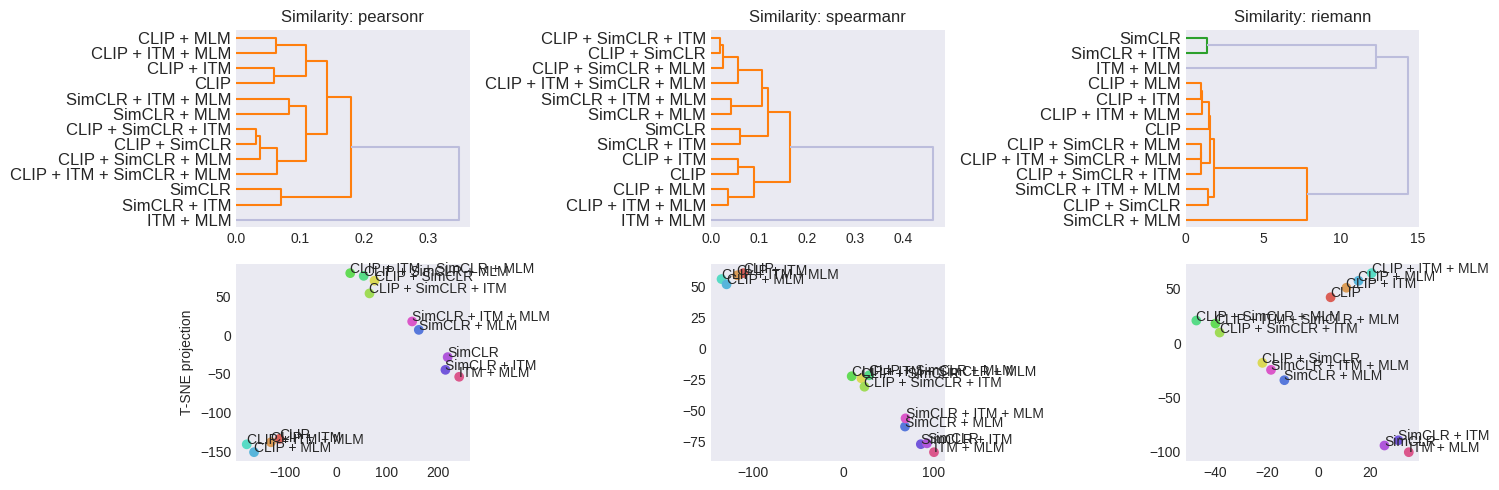

In [13]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-dark")

labels = [cfg_checkpoints[k]["model"] for k in mean_class_representations.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):
    rsa_matrix = get_rsa_matrix(mean_class_representations, similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity: {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 13),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-tsne_dendrogram-{DATASET_SPLIT}.png"),
#     bbox_inches="tight",
# )